In [1]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')

from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_sankey_diagram
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

In [2]:
model2_path = '/home/was966/Research/mims-compass/paper/checkpoint/latest/finetuner_pft_all.pt'

In [3]:
from shap.plots._beeswarm import colors
palette = [colors.blue_rgb, colors.red_rgb]

In [4]:
def map_interval(x, thr = 0):
    if abs(x) < thr:
        return 'grey'
    else:
        if x > thr:
            return  'b' #mode_palette['LFT']
        else:
            return  'r' #mode_palette['PFT']
            
def plot_gene_ranking(dfa, dfb, sample_cmap = None, use_exvar_for_y =False, top = 10,  s = 2000, figsize=(18, 15)):
    """
    Plots the rankings of features across three dataframes with their exvar values.
    
    Parameters:
    dfa, dfb, dfc (pd.DataFrame): Dataframes containing the features and their exvar values.
    cmap (dict): A dictionary mapping features to colors.
    """

    all_features = list(set(dfa.index) | set(dfb.index))

    # 使用Matplotlib的colormap生成鲜艳的颜色
    num_features = len(all_features)

    positions = {'a': 1, 'b': 2,}
    

    fig, ax = plt.subplots(figsize=figsize)
    

    # 对每个数据帧的特征按exvar值进行排序，获取排名
    sorted_indices_a = dfa['abs_shap'].sort_values(ascending=True).index
    sorted_indices_b = dfb['abs_shap'].sort_values(ascending=True).index

    top10_verlap = list(set(sorted_indices_a[-top:]) | set(sorted_indices_b[-top:]) )

    top = 10

    #top10_verlap = sorted_indices_b[-top:]
    #top10_verlap = dfb[dfb['exvar'] > 0.1].index
    if sample_cmap is None:
        x1 = dfa['abs_shap'].rank()
        x2 = dfb['abs_shap'].rank()
        sub = x1 - x2
        
        sample_cmap = sub.apply(map_interval)
        
        #sample_cmap = sub.map({True:'b', False:'r'})

    
    for feature in all_features:
        feature_color = sample_cmap[feature]

        # 绘制圆点及其标准差阴影，Y位置由exvar值决定
        if use_exvar_for_y:
            a_exvar = dfa.loc[feature, 'abs_shap'] if feature in dfa.index else None
            b_exvar = dfb.loc[feature, 'abs_shap'] if feature in dfb.index else None

    
            if a_exvar is not None:
                ax.scatter(positions['a'], a_exvar, s=a_exvar * s, marker='o', color=feature_color, alpha = 1)
                ax.scatter(positions['a'], a_exvar, s=(a_exvar + dfa.loc[feature, 'std']) * s*2, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
            if b_exvar is not None:
                ax.scatter(positions['b'], b_exvar, s=b_exvar * s, marker='o', color=feature_color, alpha=1)
                ax.scatter(positions['b'], b_exvar, s=(b_exvar + dfb.loc[feature, 'std']) * s*2, marker='o', color=feature_color, alpha=0.2, edgecolor='none')


            if a_exvar is not None and b_exvar is not None:
                ax.annotate("", xy=(positions['b'], b_exvar), xytext=(positions['a'], a_exvar),
                             arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=feature_color, lw=1.5))

            vals = ax.get_yticks()
            ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
            ax.text(positions['b']+0.05, b_exvar, feature)
            
        else:
            # 获取在每个数据帧中的排名
            a_rank = np.where(sorted_indices_a == feature)[0][0] if feature in dfa.index else None
            b_rank = np.where(sorted_indices_b == feature)[0][0] if feature in dfb.index else None

            
            
            # 绘制圆点及其标准差阴影
            if a_rank is not None:
                ax.scatter(positions['a'], a_rank, s=dfa.at[feature, 'abs_shap'] * s, marker='o', color=feature_color, alpha=1)
                ax.scatter(positions['a'], a_rank, s=(dfa.at[feature, 'abs_shap'] + dfa.at[feature, 'std']) * s*2, marker='o', color=feature_color, alpha=0.4, edgecolor='none')
            if b_rank is not None:
                ax.scatter(positions['b'], b_rank, s=dfb.at[feature, 'abs_shap'] * s, marker='o', color=feature_color, alpha=1)
                ax.scatter(positions['b'], b_rank, s=(dfb.at[feature, 'abs_shap'] + dfb.at[feature, 'std']) * s*2, marker='o', color=feature_color, alpha=0.4, edgecolor='none')

            # 绘制箭头
            if feature in top10_verlap:
                if a_rank is not None and b_rank is not None:
    
                    #ac = 'red' if a_rank > b_rank else 'blue'
                    ac = feature_color
                    ax.annotate("", xy=(positions['b'], b_rank), xytext=(positions['a'], a_rank),
                                 arrowprops=dict(arrowstyle="->, head_width=0.2, head_length=0.5", color=ac, lw=0.5, ls = '-'))

            plt.yticks(np.arange(dfa.shape[0]), sorted_indices_a)

            
       
    
    ax.tick_params(axis='both', which='major', right = False, top=True, bottom=False, direction = 'out',reset = True)
    plt.xticks([1, 2], ['Pre-training', 'Partial Finetuning'], fontsize=18)
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    #plt.title('Feature Ranking with Exvar and Std')
    #plt.xlabel('IMVigor210 cohort')
    # if not use_exvar_for_y:
    #     plt.ylabel('Ranking')
    # else:
    #     plt.ylabel('Weights')
    plt.grid(True, linestyle='--', color='#dddddd')


    if not use_exvar_for_y:
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        # 如果sorted_indices_c的长度与ax.get_yticks()返回的刻度数相同，则可以直接设置
        ax2.set_yticks(ax.get_yticks())
        # 如果sorted_indices_c是字符串列表，包含特征名称，可以直接赋值
        ax2.set_yticklabels(sorted_indices_b)

    # Legend for exvar sizes (as percentages)
    # Create custom legend
    # for i, size in enumerate(np.linspace(0.1, 0.5, 5)):
    #     ax.scatter([], [], s=size * 1000, color='black', alpha=0.3, edgecolor='grey', label=f'{size * 100:.0f}%')

    #ax.legend(title='Explained Var.', bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0., fancybox=True)
    fig.tight_layout()    
    return fig


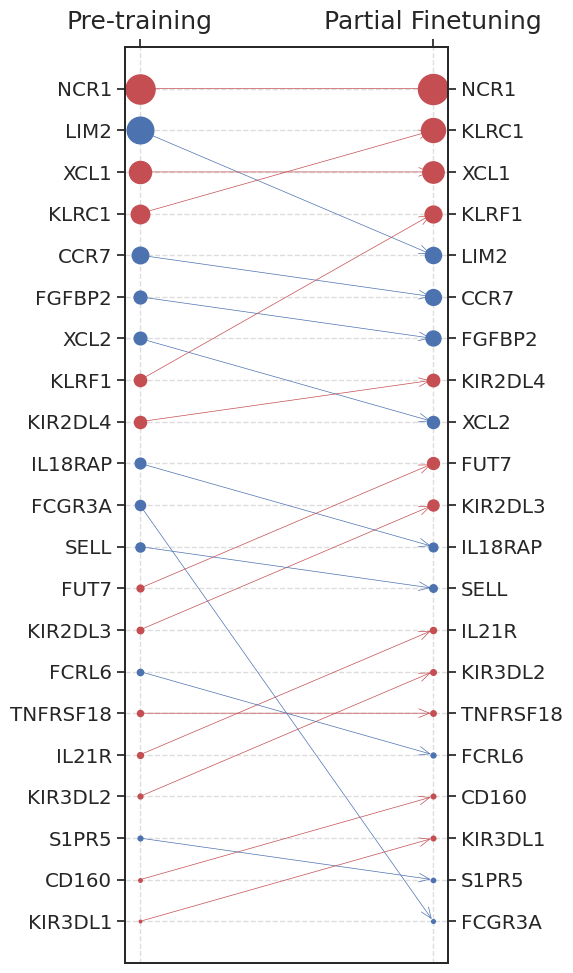

In [5]:
#concept='Macrophage'  #  Macrophage, , Cytokine, Reference

top = 20

for concept in ['NKcell' ]:#'Macrophage', 'Exhausted_Tcell', 'NKcell', 'Erythrocyte', 'Reference'
    
    save_dir = os.path.join('./results/concept', concept)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    model1_path = '/home/was966/Research/mims-compass/paper//checkpoint/latest/pretrainer.pt'
    model1 = loadcompass(model1_path, map_location = 'cpu')
    df1, fig1 = plot_sankey_diagram(model1,  concept2plot=[concept],scale_imp = False, topK_vis = top, height = 800,
                                    font=dict(size=20,  color='black')) #concept_imp_dict = concept_imp_dict1,
    fig1.write_image(os.path.join(save_dir, "%s_sankey_pretrain.svg" % concept))

    model2 = loadcompass(model2_path, map_location = 'cpu')
    df2, fig2 = plot_sankey_diagram(model2,concept2plot= [concept], scale_imp = False, topK_vis = top, height = 800,
                                    font=dict(size=20,   color='black'),  )
    fig2.write_image(os.path.join(save_dir, "%s_sankey_finetune.svg" % concept))
    
    dfa = df1.groupby(['group', 'source']).weights.sum().reset_index()
    dfa = dfa[ dfa.group == 'gene->geneset'].set_index('source').weights.to_frame('abs_shap')
    dfa['std'] = np.nan
    
    dfb = df2.groupby(['group', 'source']).weights.sum().reset_index()
    dfb = dfb[ dfb.group == 'gene->geneset'].set_index('source').weights.to_frame('abs_shap')
    dfb['std'] =  np.nan
    
    used_genes = list(set(dfa.sort_values('abs_shap').tail(top).index) | set(dfb.sort_values('abs_shap').tail(top).index))
    
    dfa = dfa.loc[used_genes]
    dfb = dfb.loc[used_genes]
    
    fig = plot_gene_ranking(dfa, dfb, None,  use_exvar_for_y = False, top = -1, figsize=(6, 10))
    fig.savefig(os.path.join(save_dir, "%s_gene_activte.svg" % concept),bbox_inches  = 'tight')

<Axes: xlabel='target'>

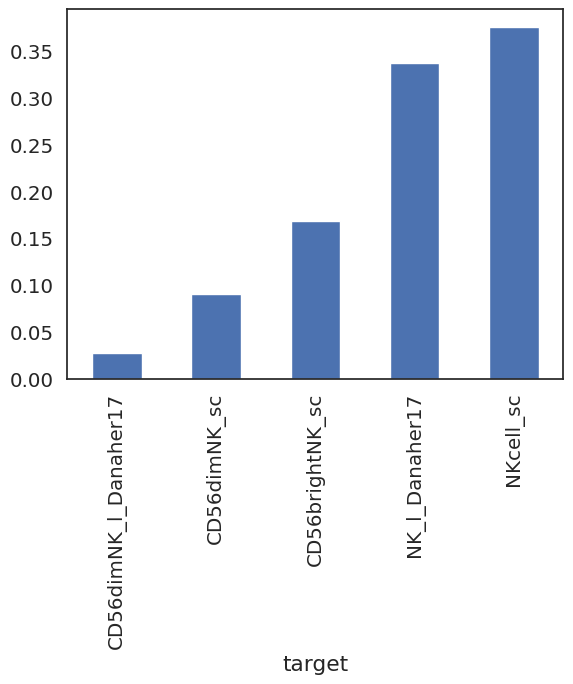

In [6]:
df1.groupby('target').weights.sum().sort_values().iloc[:-1].plot(kind='bar')

In [7]:
NKcell_idx = 13

In [8]:
weights = model1.model.latentprojector.cellpathwayprojector.cellpathway_aggregator.aggregator.attention_weights['cellpathway_%s' % NKcell_idx].cpu().detach().numpy()

In [9]:
weights

array([[-0.52757204],
       [-2.3220692 ],
       [-1.1516751 ],
       [ 0.16427788],
       [ 0.27165338]], dtype=float32)

In [10]:
# CD56brightNK_sc
# CD56dimNK_l_Danaher17
# CD56dimNK_sc
# NK_l_Danaher17
# NKcell_sc

In [11]:
df1.groupby('target').size()

target
CD56brightNK_sc          6
CD56dimNK_l_Danaher17    4
CD56dimNK_sc             6
NK_l_Danaher17           3
NKcell                   5
NKcell_sc                6
dtype: int64

In [78]:
dfg1

,source,target,weights,group,concept,source_color,target_color,Subtype
0,XCL1,CD56brightNK_sc,0.041091,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
1,SELL,CD56brightNK_sc,0.021778,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
2,CCR7,CD56brightNK_sc,0.071156,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
3,FUT7,CD56brightNK_sc,0.012079,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
4,KLRC1,CD56brightNK_sc,0.013053,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
5,TNFRSF18,CD56brightNK_sc,0.009672,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{bright}$
0,IL21R,CD56dimNK_l_Danaher17,0.009033,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{dim}$
1,KIR2DL3,CD56dimNK_l_Danaher17,0.011209,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{dim}$
2,KIR3DL1,CD56dimNK_l_Danaher17,0.001717,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{dim}$
3,KIR3DL2,CD56dimNK_l_Danaher17,0.006103,gene->geneset,NKcell,#9e9d93,#ff7266,$CD56^{dim}$


In [85]:
dfg1 = df1[df1.group == 'gene->geneset']
dfg1.weights = dfg1.source.map(df1.groupby('source').weights.sum()).astype(float)
def subtyping(x):
    if 'CD56bright' in x:
        return '$CD56^{bright}$'
    elif 'CD56dim' in x:
        return '$CD56^{dim}$'
    else:
        return 'Other'

#$CD56^{bright}$
dfg1['Subtype'] = dfg1.target.apply(subtyping)
dfg1 = dfg1[dfg1.Subtype != 'Other']

$CD56^{dim}$ vs. $CD56^{bright}$: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=8.000e+00


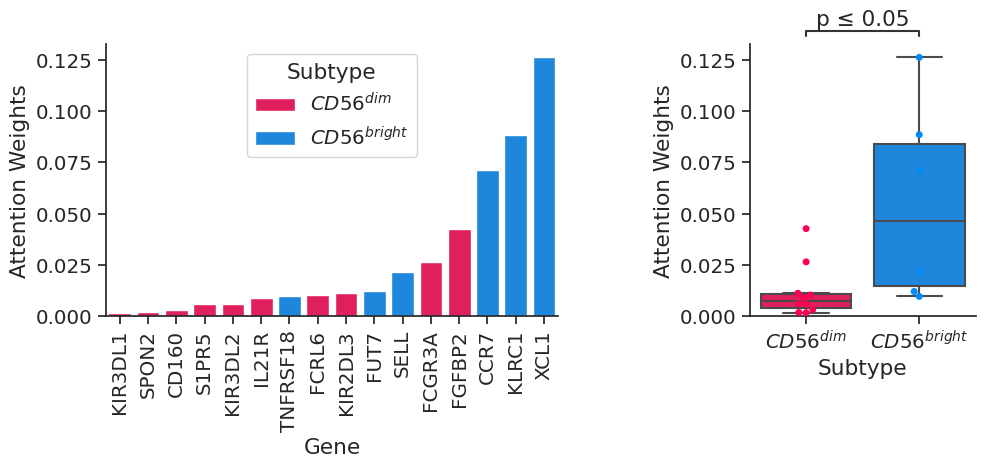

In [88]:
from shap.plots import colors
from statannotations.Annotator import Annotator


palette =  [colors.red_rgb, colors.blue_rgb] #[bright[-2], bright[-1]]


sns.set(style = 'white', font_scale=1.3)

data = dfg1.sort_values('weights')[['source','weights', 'Subtype']].reset_index(drop=True)


fig, axes = plt.subplots(figsize=(10, 5), ncols=2, width_ratios = [2,1], sharey=True)
ax1, ax2 = axes

#sns.barplot(data=data, y = 'weights', x = 'source', hue = 'subtype', palette=palette)
sns.barplot(x='source', y='weights', hue='Subtype', data=data, dodge=False,ax=ax1, palette=palette)



data = dfg1.sort_values('weights')[['source','weights', 'Subtype']]
sns.boxplot(data = data, x = 'Subtype', y = 'weights', fliersize = 0, palette=palette, ax=ax2)
sns.swarmplot(data = data, x = 'Subtype', y = 'weights', palette=palette, linewidth=0.01, ax=ax2)

    
box_pairs = [('$CD56^{dim}$', '$CD56^{bright}$')]
annotator = Annotator(ax = ax2, pairs=box_pairs, data=data, x= 'Subtype', y='weights', )
annotator.configure(test='Mann-Whitney', text_format='simple',  loc='outside', show_test_name = False,
                    #pvalue_format = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]],
                    comparisons_correction = None,)
annotator.apply_and_annotate()


for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1.set_ylabel('Attention Weights')
ax2.set_ylabel('Attention Weights')

ax1.set_xlabel('Gene')
ax2.set_xlabel('Subtype')

fig.tight_layout(w_pad = 5)
fig.savefig("./results/NKcell_subtype.svg"  , bbox_inches = 'tight')
fig.savefig("./results/NKcell_subtype.pdf"  , bbox_inches = 'tight')